In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
from mtcnn import MTCNN
from tqdm import tqdm
import numpy as np
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

from PIL import Image as pil
from pkg_resources import parse_version

if parse_version(pil.__version__)>=parse_version('10.0.0'):
    pil.ANTIALIAS=pil.LANCZOS

import tflearn
from tflearn.data_augmentation import ImageAugmentation
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.estimator import regression



Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)



# Face Detection and Dataset Generator

In [2]:
def generator():
    detector = MTCNN()
    cap = cv2.VideoCapture(0)
    id = 2
    name = "Anurag"
    img_id = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to capture frame from webcam.")
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_faces = detector.detect_faces(rgb_frame)
    
        for face in input_faces:
            x, y, width, height = face['box']
            cropped_face = gray[y:y+height, x:x+width]
            img_id += 1
            face = cv2.resize(cropped_face, (200, 200))
            
            file_name_path = f"DataSet/{name}" + "." + str(id) + "."+ str(img_id) + ".jpg"
            # file_name_path = f"visualization/{name}" + "." + str(id) + "."+ str(img_id) + ".jpg"
            
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(img_id), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow("Face", face)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
    cap.release()
    cv2.destroyAllWindows()
    print("DataSet Successfully Generated")
# generator()

# Feature Engineering

In [3]:
def my_label(image_name):
    name = image_name.split('.')[0]
    if name == "Bharat":
        return np.array([1,0,0])
    elif name == "Anurag":
        return np.array([0,1,0])
    elif name == "Pawan":
        return np.array([0,0,1])
        

In [4]:
def my_data():
    data= []
    for img in tqdm(os.listdir("DataSet")):
        path = os.path.join("DataSet", img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50, 50))
        data.append([np.array(img_data), my_label(img)])
    shuffle(data)
    return data
data = my_data()

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 659.99it/s]


# Train and Test Split

In [5]:
data = my_data()
train = data[:2400]
test = data[2400:]
X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
y_train = np.array([i[1] for i in train])
X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
y_test = np.array([i[1] for i in test])
print(X_train.shape)
print(X_test.shape)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1148.97it/s]

(2400, 50, 50, 1)
(600, 50, 50, 1)


In [6]:
# for i in train: print(np.argmax(i[1]))

# Model

In [7]:
tf.compat.v1.reset_default_graph()
def build_model(img_aug):
    convnet = input_data(shape=[50, 50, 1], data_augmentation=img_aug)
    
    convnet = conv_2d(convnet, 32, 5, activation= 'relu')
    convnet = batch_normalization(convnet)
    convnet = max_pool_2d(convnet, 5)
    convnet = dropout(convnet, 0.5) 
    
    convnet = conv_2d(convnet, 64, 5, activation='relu')
    convnet = batch_normalization(convnet)
    convnet = max_pool_2d(convnet, 5)
    convnet = dropout(convnet, 0.5)
    
    convnet = conv_2d(convnet, 128, 5, activation='relu')
    convnet = batch_normalization(convnet)
    convnet = max_pool_2d(convnet, 5)
    convnet = dropout(convnet, 0.5)
    
    convnet = conv_2d(convnet, 64, 5, activation='relu')
    convnet = batch_normalization(convnet)
    convnet = max_pool_2d(convnet, 5)
    convnet = dropout(convnet, 0.5)
    
    convnet = conv_2d(convnet, 32, 5, activation='relu')
    convnet = batch_normalization(convnet)
    convnet = max_pool_2d(convnet, 5)
    convnet = dropout(convnet, 0.5)
    
    convnet = fully_connected(convnet, 1024, activation='relu')
    convnet = batch_normalization(convnet)
    convnet = dropout(convnet, 0.5)
    
    convnet = fully_connected(convnet, 3, activation='softmax')
    
    convnet = regression(convnet, optimizer='adam', learning_rate = 0.001, loss='categorical_crossentropy')
    
    model = tflearn.DNN(convnet, tensorboard_verbose=1)
    
    return model

In [8]:
# Image Augmentation Settings
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_flip_updown()
img_aug.add_random_rotation(max_angle=25.)
img_aug.add_random_blur(sigma_max=3.)

model = build_model(img_aug=img_aug)
model.fit(X_train, y_train, n_epoch=35, validation_set=(X_test, y_test), show_metric = True, run_id="Train" )

Training Step: 1329  | total loss: 0.16805 | time: 6.568s
| Adam | epoch: 035 | loss: 0.16805 - acc: 0.9497 -- iter: 2368/2400
Training Step: 1330  | total loss: 0.17997 | time: 7.744s
| Adam | epoch: 035 | loss: 0.17997 - acc: 0.9470 | val_loss: 0.01196 - val_acc: 0.9983 -- iter: 2400/2400
--


In [9]:
# model.summary()

# Feature Engineering for Predicting 

In [10]:
# Validation Image Processing
def data_for_visualization():
    Vdata = []
    for img in tqdm(os.listdir("visualization")):
        path = os.path.join("visualization", img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        Vdata.append([np.array(img_data), img_num])
    shuffle(Vdata)
    return Vdata

In [11]:
# Vdata = data_for_visualization()
# for i in Vdata:
#     print(i)

In [15]:
from datetime import date
def attendance_update(file_path, name, user_name):
    status = None
    if user_name == name:
        status = 'Present'
    else:
        status = 'Absent'
    
    today = date.today()
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active 
    # Update a cell value
    sheet['A1'] = f'{name}'
    sheet['B1'] = status
    sheet['C1'] = today
    workbook.save(file_path)
    print('Updated Excel')

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1031.81it/s]


Enter your name:  Pawan


Updated Excel
['Bharat']


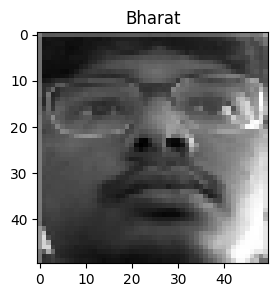

In [17]:
Vdata = data_for_visualization()

file_path = 'Attendance_Log.xlsx'
fig = plt.figure(figsize=(4,3))

for data in Vdata:
    user_name = input("Enter your name: ")
    img_data = data[0]
    new_data = img_data.reshape(50,50,1)
    prediction = model.predict([new_data])[0]
    # print(prediction)

    if np.argmax(prediction) == 0:
        name = 'Bharat'
    elif np.argmax(prediction) == 1:
        name = 'Anurag'
    else:
        name = 'Pawan'
        
    attendance_update(file_path, name, user_name)
    lst = []
    lst.append(name)
    print(lst)

    plt.imshow(img_data, cmap= 'gray')
    plt.title(name)
plt.show()    


In [16]:
model.save("Model.keras")

INFO:tensorflow:C:\Users\91798\OneDrive\Desktop\In-House\Model.keras is not in all_model_checkpoint_paths. Manually adding it.


In [21]:
def validation_screenshot():
    Vdata = data_for_visualization()
    cap = cv2.VideoCapture(0)
    detector = MTCNN()
    id = 1
    img_id = 0
    file_name = "Stranger"
    while True:
        
        ret, frame = cap.read()
    
        for data in Vdata:
            img_data = data[0]
            new_data = img_data.reshape(50,50,1)
            prediction = model.predict([new_data])[0]
        
            if np.argmax(prediction) == 0:
                name = 'Bharat'
            elif np.argmax(prediction) == 1:
                name = 'Shyam'
            else:
                name = 'Pawan'
             
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector.detect_faces(frame_rgb)
        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
            image = frame[y:y+h, x:x+w]
            face = cv2.resize(image, (200, 200))
            # cv2.putText(frame, name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        
            cv2.imshow("Recognition", frame)
            
            
            if cv2.waitKey(1) == ord('v'):
                img_id+=1
                file_name_path = f"visualization/{file_name}" + "." + str(id) + "."+ str(img_id) + ".jpg"
                cv2.imwrite(file_name_path, face)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()
    

"""
Need to aad a key to terminate the process.
Need to aad key to take a screenshot and save it to the desired file location.
"""

# validation_screenshot()

0it [00:00, ?it/s]


KeyboardInterrupt: 